<a href="https://colab.research.google.com/github/BenBeharUNSW/Project/blob/main/VIC_Demand__prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from datetime import datetime

Reading and preparing the data

In [2]:
# Read the CSV file
df = pd.read_csv('totaldemand_vic.csv')

# Ensure the DATETIME column is in datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Set the DATETIME column as the index
df.set_index('DATETIME', inplace=True)

group by hour

In [3]:
# Resample to 1-hour intervals. Here we're summing the total demand, but you could also use .mean() or other methods
df_hourly = df.resample('1H').sum()

# Resetting the index to have DATETIME as a column again, if needed
df_hourly.reset_index(inplace=True)

# Show the first few rows of the resampled DataFrame
print(df_hourly.head())

             DATETIME  TOTALDEMAND
0 2010-01-01 00:00:00     10537.14
1 2010-01-01 01:00:00     10243.43
2 2010-01-01 02:00:00      9842.33
3 2010-01-01 03:00:00      9138.33
4 2010-01-01 04:00:00      8873.81


<ipython-input-3-ac465999d425>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hourly = df.resample('1H').sum()


split weekends and week days

In [4]:
# Check if each date is a weekend (Saturday=5, Sunday=6)
is_weekend = df.index.weekday > 4

# Split the DataFrame into weekdays and weekends
df_weekdays = df[~is_weekend]
df_weekends = df[is_weekend]

# Now, df_weekdays contains only the weekdays data, and df_weekends contains only the weekends data

# Optionally, print the first few rows to verify
print("Weekdays DataFrame:")
print(df_weekdays.head())

print("\nWeekends DataFrame:")
print(df_weekends.head())

Weekdays DataFrame:
                     TOTALDEMAND REGIONID
DATETIME                                 
2010-01-01 00:00:00      5426.12     VIC1
2010-01-01 00:30:00      5111.02     VIC1
2010-01-01 01:00:00      4960.03     VIC1
2010-01-01 01:30:00      5283.40     VIC1
2010-01-01 02:00:00      5046.15     VIC1

Weekends DataFrame:
                     TOTALDEMAND REGIONID
DATETIME                                 
2010-01-02 00:00:00      4802.54     VIC1
2010-01-02 00:30:00      4622.89     VIC1
2010-01-02 01:00:00      4428.91     VIC1
2010-01-02 01:30:00      4719.84     VIC1
2010-01-02 02:00:00      4552.10     VIC1


Compparsion plot between weekends and week days with years cariables (2010-2021)

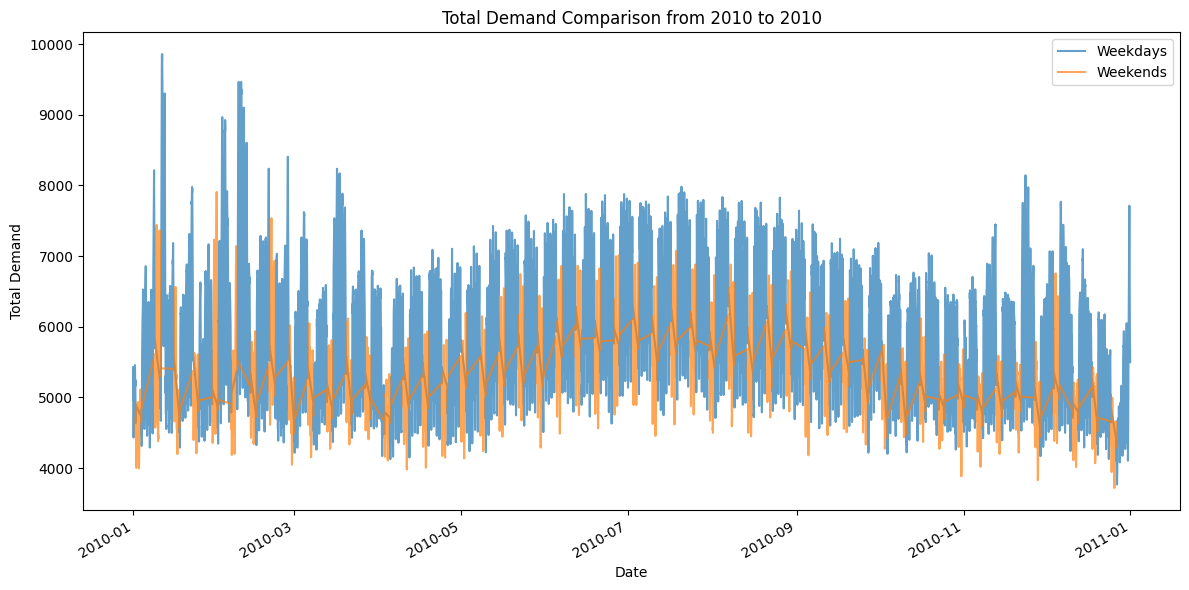

In [8]:
def plot_comparison(year_start, year_end):
    # Filter DataFrames for the specified years
    mask_weekdays = (df_weekdays.index.year >= year_start) & (df_weekdays.index.year <= year_end)
    df_weekdays_filtered = df_weekdays.loc[mask_weekdays]

    mask_weekends = (df_weekends.index.year >= year_start) & (df_weekends.index.year <= year_end)
    df_weekends_filtered = df_weekends.loc[mask_weekends]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot each DataFrame. Adjust the column name 'TOTALDEMAND' if necessary
    df_weekdays_filtered['TOTALDEMAND'].plot(label='Weekdays', alpha=0.7)
    df_weekends_filtered['TOTALDEMAND'].plot(label='Weekends', alpha=0.7)

    plt.title(f'Total Demand Comparison from {year_start} to {year_end}')
    plt.xlabel('Date')
    plt.ylabel('Total Demand')
    plt.legend()
    plt.tight_layout()
    plt.show()

# calling the function
plot_comparison(2010, 2010)

prediction total demand until 2030 - linera regrassion

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


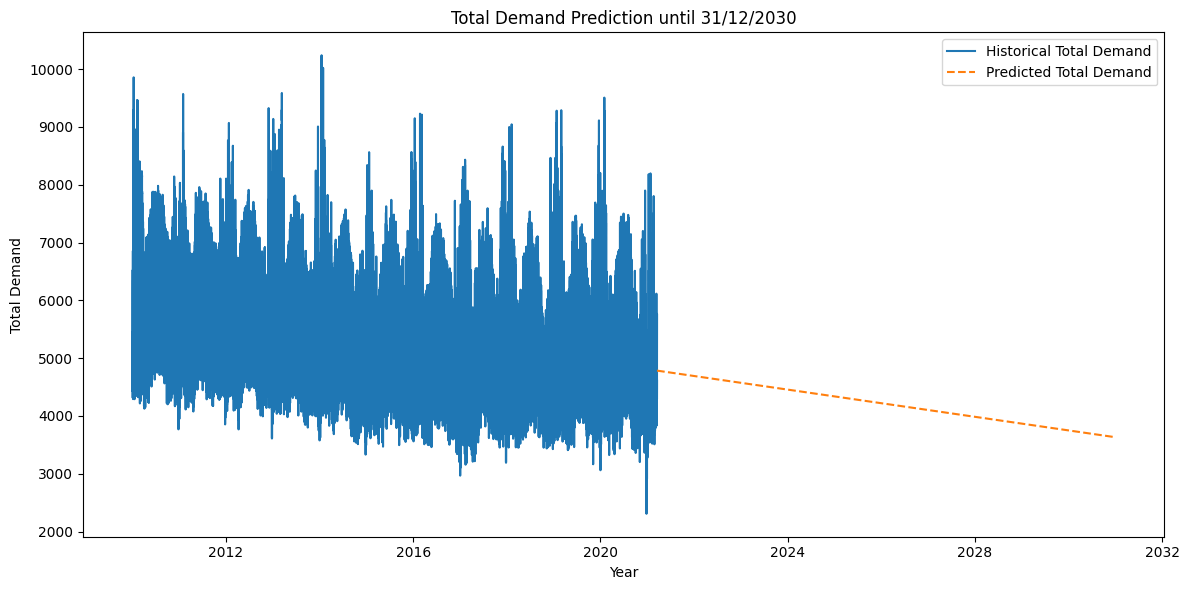

In [11]:

def predict_and_plot(df, start_year, end_year):
    # Filter the DataFrame for the specified years
    mask = (df.index.year >= start_year) & (df.index.year <= end_year)
    df_filtered = df.loc[mask]

    # Prepare the data for the model
    # Convert dates into numerical format (e.g., number of days since start) for modeling
    df_filtered['Day'] = (df_filtered.index - df_filtered.index.min()).days

    # Features and target variable
    X = df_filtered[['Day']]
    y = df_filtered['TOTALDEMAND']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions for the given period
    future_days = (pd.to_datetime('2030-12-31') - df_filtered.index.min()).days
    future_dates = pd.date_range(start=df_filtered.index.max(), end='2030-12-31', freq='D')
    future_dates_num = (future_dates - df_filtered.index.min()).days
    future_predictions = model.predict(future_dates_num.to_frame())

    # Plotting historical and predicted data
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, y, label='Historical Total Demand')
    plt.plot(future_dates, future_predictions, label='Predicted Total Demand', linestyle='--')

    plt.title('Total Demand Prediction until 31/12/2030')
    plt.xlabel('Year')
    plt.ylabel('Total Demand')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Call the function with the DataFrame, start year, and end year
predict_and_plot(df_weekdays, 2010, 2021)

Random forest regressor

<ipython-input-21-5c5cfdde39de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-21-5c5cfdde39de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.dayofweek
<ipython-input-21-5c5cfdde39de>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

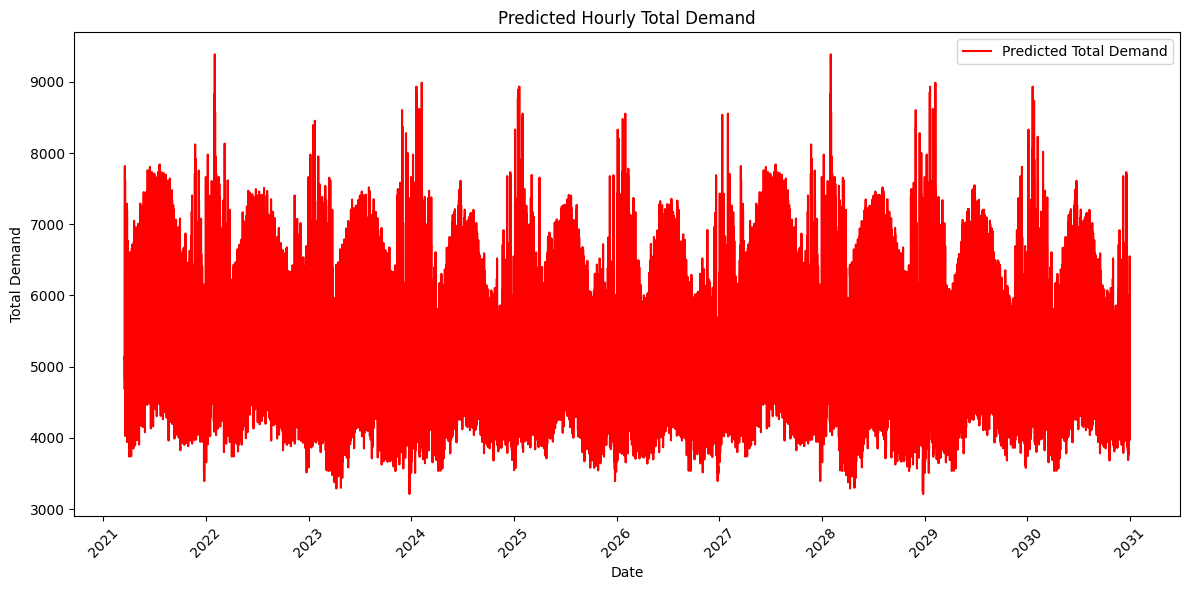

In [21]:

def create_features(df):
    """Generate time-based features from the datetime index."""
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    return df

def predict_hourly_demand(df):
    # Ensure the datetime is the index and create features
    df = create_features(df)

    # Prepare features and target
    X = df[['hour', 'day_of_week', 'day_of_month', 'month']]
    y = df['TOTALDEMAND']

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X, y)

    # Create a DataFrame for predictions up to December 31, 2030
    future_dates = pd.date_range(start=df.index.max(), end='2030-12-31', freq='H')
    df_future = pd.DataFrame(index=future_dates)
    df_future = create_features(df_future)

    # Predict
    X_future = df_future[['hour', 'day_of_week', 'day_of_month', 'month']]
    df_future['TOTALDEMAND_PREDICTION'] = model.predict(X_future)

    # Plotting a sample
    plt.figure(figsize=(12, 6))
    # Plot a small sample of the future predictions
    sample_future = df_future.loc['2010-01-01':'2030-12-31']
    plt.plot(sample_future.index, sample_future['TOTALDEMAND_PREDICTION'], label='Predicted Total Demand', color='red')
    plt.title('Predicted Hourly Total Demand')
    plt.xlabel('Date')
    plt.ylabel('Total Demand')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_future

# Call the function with the DataFrame
df_future_predictions = predict_hourly_demand(df_weekdays)